In [1]:
%matplotlib inline



# Compute and visualize ERDS maps

This example calculates and displays ERDS maps of event-related EEG data.
ERDS (sometimes also written as ERD/ERS) is short for event-related
desynchronization (ERD) and event-related synchronization (ERS)
:footcite:`PfurtschellerLopesdaSilva1999`. Conceptually, ERD corresponds to a
decrease in power in a specific frequency band relative to a baseline.
Similarly, ERS corresponds to an increase in power. An ERDS map is a
time/frequency representation of ERD/ERS over a range of frequencies
:footcite:`GraimannEtAl2002`. ERDS maps are also known as ERSP (event-related
spectral perturbation) :footcite:`Makeig1993`.

In this example, we use an EEG BCI data set containing two different motor
imagery tasks (imagined hand and feet movement). Our goal is to generate ERDS
maps for each of the two tasks.

First, we load the data and create epochs of 5s length. The data set contains
multiple channels, but we will only consider C3, Cz, and C4. We compute maps
containing frequencies ranging from 2 to 35Hz. We map ERD to red color and ERS
to blue color, which is customary in many ERDS publications. Finally, we
perform cluster-based permutation tests to estimate significant ERDS values
(corrected for multiple comparisons within channels).


In [18]:
# Authors: Clemens Brunner <clemens.brunner@gmail.com>
#          Felix Klotzsche <klotzsche@cbs.mpg.de>
#
# License: BSD-3-Clause

As usual, we import everything we need.



In [1]:
#librerias
import numpy as np
import time
from datetime import datetime
#from loaddata import *

#sklearn
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics as met
import joblib

import matplotlib
#new
from matplotlib.colors import TwoSlopeNorm
from mne.time_frequency import tfr_multitaper
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import pandas as pd
import seaborn as sns

#mne
import mne
from mne.decoding import CSP
from mne.channels import read_layout
from mne.channels import make_standard_montage
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs,
                               compute_proj_ecg, compute_proj_eog)
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne import Epochs, pick_types, events_from_annotations


#matplotlib.use('Qt5Agg')

In [2]:
path="../../../LSL-BCI/DATA/Experiment_5/Data/T1/"
raw = mne.io.read_raw_fif(path + "/data_eeg.fif", preload=True)
events = mne.read_events(path + "/data-eve.fif")
events

Opening raw data file ../../../LSL-BCI/DATA/Experiment_5/Data/T1//data_eeg.fif...
    Range : 0 ... 133704 =      0.000 ...   534.816 secs
Ready.
Reading 0 ... 133704  =      0.000 ...   534.816 secs...


array([[  6259,      0,      1],
       [  9280,      0,      0],
       [ 12287,      0,      1],
       [ 15318,      0,      0],
       [ 18291,      0,      0],
       [ 21320,      0,      0],
       [ 24324,      0,      0],
       [ 26823,      0,      1],
       [ 29728,      0,      1],
       [ 32484,      0,      1],
       [ 39834,      0,      0],
       [ 42860,      0,      0],
       [ 45879,      0,      1],
       [ 48899,      0,      1],
       [ 51924,      0,      1],
       [ 54948,      0,      1],
       [ 57955,      0,      0],
       [ 60992,      0,      1],
       [ 63976,      0,      0],
       [ 66789,      0,      0],
       [ 74749,      0,      0],
       [ 77684,      0,      0],
       [ 80712,      0,      0],
       [ 83738,      0,      1],
       [ 86767,      0,      1],
       [ 89798,      0,      1],
       [ 92794,      0,      0],
       [ 95826,      0,      0],
       [ 98880,      0,      1],
       [101910,      0,      1],
       [10

In [3]:
events = events[:30]
events.shape

(30, 3)

First, we load and preprocess the data. We use runs 6, 10, and 14 from
subject 1 (these runs contains hand and feet motor imagery).



In [4]:
#filtrar channles
raw.pick_channels(ch_names=['C3','Cz','C4','P3','Pz','P4','O1','O2'])
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



<Raw | data_eeg.fif, 8 x 133705 (534.8 s), ~8.2 MB, data loaded>

Now we can create 5-second epochs around events of interest.



In [5]:
tmin, tmax = -1, 4
event_ids = dict(left=0, right=1)  # map event IDs to tasks

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 1501 original time points ...
0 bad epochs dropped



Here we set suitable values for computing ERDS maps. Note especially the
``cnorm`` variable, which sets up an *asymmetric* colormap where the middle
color is mapped to zero, even though zero is not the middle *value* of the
colormap range. This does two things: it ensures that zero values will be
plotted in white (given that below we select the ``RdBu`` colormap), and it
makes synchronization and desynchronization look equally prominent in the
plots, even though their extreme values are of different magnitudes.



In [6]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

Finally, we perform time/frequency decomposition over all epochs.



Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.761310
stat_fun(H1): min=-22.533235 max=2.638849
Running initial clustering
Found 9 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-22.533235 max=2.638849
Running initial clustering
Found 71 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.761310
stat_fun(H1): min=-36.620510 max=2.698165
Running initial clustering
Found 11 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-36.620510 max=2.698165
Running initial clustering
Found 82 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.761310
stat_fun(H1): min=-42.223963 max=3.100151
Running initial clustering
Found 8 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-42.223963 max=3.100151
Running initial clustering
Found 81 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


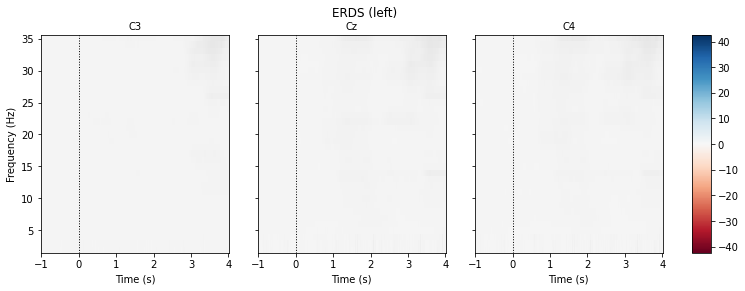

Using a threshold of 1.761310
stat_fun(H1): min=-20.684469 max=3.993111
Running initial clustering
Found 12 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-20.684469 max=3.993111
Running initial clustering
Found 94 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.761310
stat_fun(H1): min=-18.826531 max=5.115998
Running initial clustering
Found 19 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-18.826531 max=5.115998
Running initial clustering
Found 95 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.761310
stat_fun(H1): min=-16.203663 max=4.010098
Running initial clustering
Found 14 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.761310
stat_fun(H1): min=-16.203663 max=4.010098
Running initial clustering
Found 87 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied


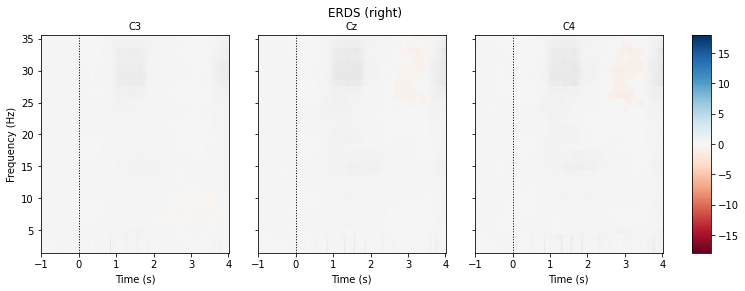

In [7]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Similar to `~mne.Epochs` objects, we can also export data from
`~mne.time_frequency.EpochsTFR` and `~mne.time_frequency.AverageTFR` objects
to a :class:`Pandas DataFrame <pandas.DataFrame>`. By default, the `time`
column of the exported data frame is in milliseconds. Here, to be consistent
with the time-frequency plots, we want to keep it in seconds, which we can
achieve by setting ``time_format=None``:



In [27]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C3,Cz,C4
0,-1.004,2.0,0,right,-0.679362,0.278148,-0.783732
1,-0.996,2.0,0,right,-0.940614,-0.405388,-0.917014
2,-0.988,2.0,0,right,-0.740416,-0.916212,-0.877561
3,-0.980,2.0,0,right,-0.424683,-0.314915,-0.532815
4,-0.972,2.0,0,right,-0.884462,-0.711977,-0.890819


This allows us to use additional plotting functions like
:func:`seaborn.lineplot` to plot confidence bands:



Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


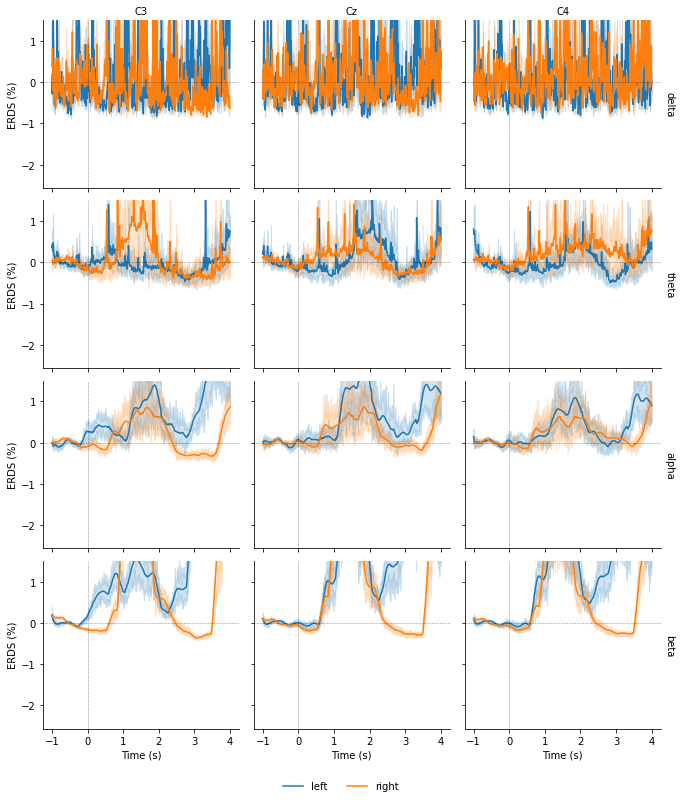

In [28]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Having the data as a DataFrame also facilitates subsetting,
grouping, and other transforms.
Here, we use seaborn to plot the average ERDS in the motor imagery interval
as a function of frequency band and imagery condition:



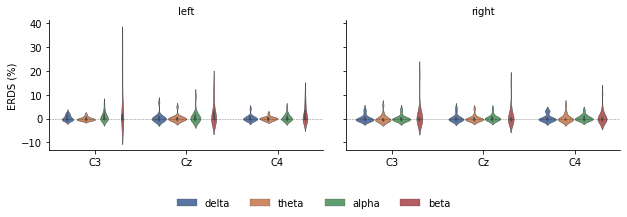

In [30]:
df_mean = (df.query('time > 1')
             .groupby(['condition', 'epoch', 'band', 'channel'])[['value']]
             .mean()
             .reset_index())

g = sns.FacetGrid(df_mean, col='condition', col_order=['left', 'right'],
                  margin_titles=True)
g = (g.map(sns.violinplot, 'channel', 'value', 'band', n_boot=10,
           palette='deep', order=['C3', 'Cz', 'C4'],
           hue_order=freq_bands_of_interest,
           linewidth=0.5).add_legend(ncol=4, loc='lower center'))

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

In [31]:
e0= epochs[epochs.events[:,2]==0]
e1= epochs[epochs.events[:,2]==1]

In [37]:
e0.load_data()  # Resampling to save memory.
e0.resample(250, npad='auto')
e1.load_data()  # Resampling to save memory.
e1.resample(250, npad='auto')
evoked_left = e0.average()
evoked_right = e1.average()

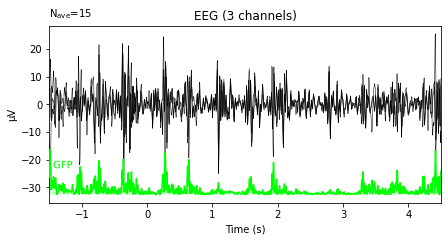

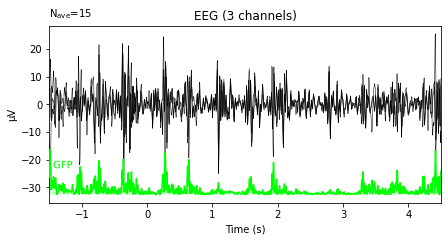

In [38]:
evoked_left.plot(window_title='Standard', gfp=True, time_unit='s', scalings=None)

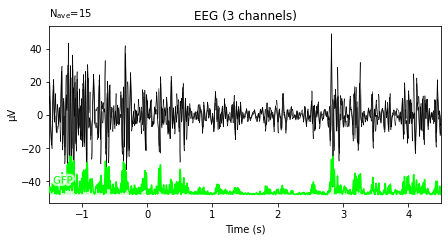

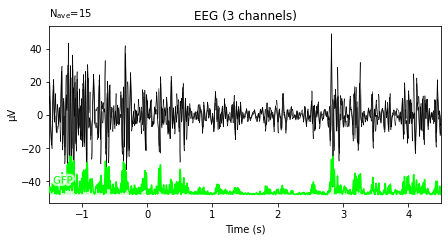

In [41]:
evoked_right.plot(window_title='Standard', gfp=True, time_unit='s', scalings=None)

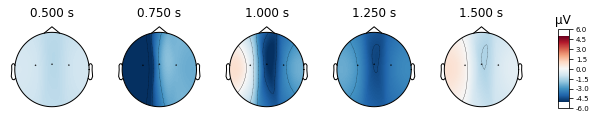

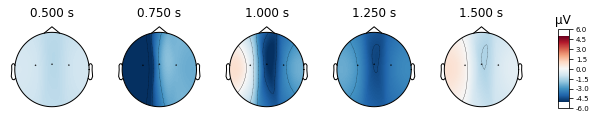

In [39]:
evoked_left.plot_topomap(times=[0.5, 0.75, 1, 1.25, 1.5], ch_type='eeg', vmin=-5, vmax=5)

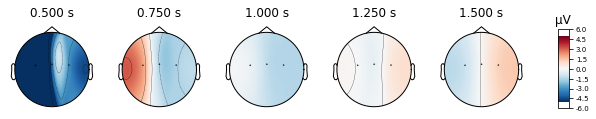

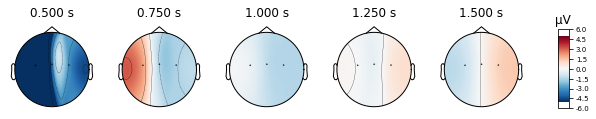

In [40]:
evoked_right.plot_topomap(times=[0.5, 0.75, 1, 1.25, 1.5], ch_type='eeg', vmin=-5, vmax=5)

## References
.. footbibliography::

